# Post Process Lidar

In this notebook im going to up attempt to interpret missing boxes from large datasets
for example missing boxes in the 100m data will be interpreted as having the same results
as the 1000m box they fall inside and then the same will be done to the 10m

Imagine a bad cop drama with "the computer expert" saying enhancing repeatedly, and basically that

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import os
from datetime import datetime
import matplotlib.pyplot as plt

In [2]:
def lp(v):
    print(f"[{datetime.now()}] {v}")

lp("starting...")

[2025-04-02 11:06:45.190566] starting...


In [3]:
resolutions = sorted([1000,100,10], reverse=True)
lp(f"Resolutions:  {resolutions}")
outPath = f"{os.path.curdir}{os.sep}output{os.sep}"
lp(f"outPath: {outPath}")
files = {r:f"{outPath}AggregateLidarData_{r}m.parquet" for r in resolutions}

[2025-04-02 11:06:45.195394] Resolutions:  [1000, 100, 10]
[2025-04-02 11:06:45.195510] outPath: ./output/


In [4]:
lp(f"Loading files:  {files}")
startTime = datetime.now()
datas = {r:gpd.read_parquet(files[r]) for r in resolutions}
lp(f"All files loaded in {datetime.now()-startTime}")

[2025-04-02 11:06:45.200908] Loading files:  {1000: './output/AggregateLidarData_1000m.parquet', 100: './output/AggregateLidarData_100m.parquet', 10: './output/AggregateLidarData_10m.parquet'}
[2025-04-02 11:06:50.892591] All files loaded in 0:00:05.691505


In [5]:
datas[1000].head(2)

,geometry,AltitudeTotal,WaterTotal,Int,Total,RunTime
4,"POLYGON ((777039 3311888, 777039 3312888, 7760...",3.124952e+09,845.0,1.218623e+09,1588830.0,0 days 00:00:01.036888
5,"POLYGON ((777039 3312888, 777039 3313888, 7760...",6.639287e+09,911.0,1.180152e+09,1289143.0,0 days 00:00:02.412734


In [6]:
for key in datas.keys():
    lp(f"Processing aggregate columns for {key}m resolution")
    datas[key]['MeanAltitude'] = datas[key]['AltitudeTotal'] / datas[key]['Total'] * (0.001 * 3.28084)  #multiple by scale and convert meters 2 feet
    datas[key]['MeanIntensity'] = datas[key]['Int'] / datas[key]['Total']
    datas[key]['PercentWater'] = datas[key]['WaterTotal'] / datas[key]['Total'] * 100.0


[2025-04-02 11:06:50.917493] Processing aggregate columns for 1000m resolution
[2025-04-02 11:06:50.920828] Processing aggregate columns for 100m resolution
[2025-04-02 11:06:50.924254] Processing aggregate columns for 10m resolution


<Axes: >

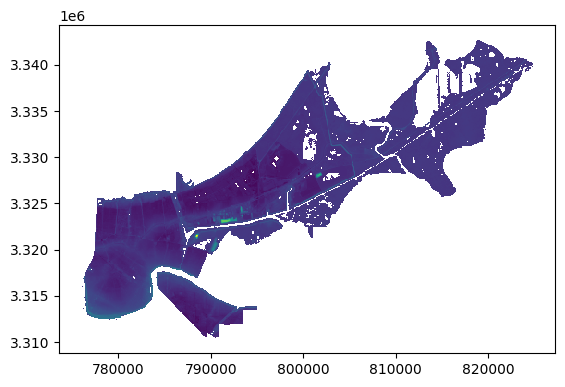

In [7]:
datas[100].plot(column='MeanAltitude')

In [8]:
for r in resolutions:
    totalMissing = np.count_nonzero( datas[r]['Total'] == 0 )
    percentMissing = totalMissing / datas[r].shape[0] * 100.0
    lp( f"For {r}m missing\t{totalMissing}/{datas[r].shape[0]}  ({round(percentMissing,1)}%)")

[2025-04-02 11:06:55.848953] For 1000m missing	35/648  (5.4%)
[2025-04-02 11:06:55.849403] For 100m missing	8067/55104  (14.6%)
[2025-04-02 11:06:55.855345] For 10m missing	1359996/5394495  (25.2%)


In [9]:
def process(lowRes, highRes, columns=['MeanAltitude', 'MeanIntensity', 'PercentWater']):
    startTime = datetime.now()
    output = lowRes.copy()
    totalChanges = 0
    for idx, box in highRes[~pd.isna(highRes['MeanAltitude'])].iterrows():
        
        mask = np.logical_and(output.intersects( box['geometry'] ), output['Total']==0)
        for col in columns: 
            output.loc[mask,col] = box[col]

        totalChanges += np.count_nonzero(mask)

    lp(f"{totalChanges} processed in {datetime.now()-startTime}")
    return output

outputs = {}
outputs[1000] = datas[1000]
lp("Processing 100m output")
outputs[100] = process(datas[100], datas[1000])

[2025-04-02 11:06:55.860326] Processing 100m output
[2025-04-02 11:06:58.966952] 8439 processed in 0:00:03.105945


In [10]:
outputs[100].head()

,geometry,AltitudeTotal,WaterTotal,Int,Total,RunTime,MeanAltitude,MeanIntensity,PercentWater
76,"POLYGON ((776139 3315488, 776139 3315588, 7760...",0.0,0.0,0.0,0.0,0 days 00:00:00.228102,9.701096,626.228821,0.137147
77,"POLYGON ((776139 3315588, 776139 3315688, 7760...",0.0,0.0,0.0,0.0,0 days 00:00:00.200766,9.701096,626.228821,0.137147
78,"POLYGON ((776139 3315688, 776139 3315788, 7760...",0.0,0.0,0.0,0.0,0 days 00:00:00.198523,9.701096,626.228821,0.137147
79,"POLYGON ((776139 3315788, 776139 3315888, 7760...",0.0,0.0,0.0,0.0,0 days 00:00:00.181250,7.899859,534.540656,0.134719
80,"POLYGON ((776139 3315888, 776139 3315988, 7760...",0.0,0.0,0.0,0.0,0 days 00:00:00.190977,7.899859,534.540656,0.134719


In [ ]:
lp("Processing 10m  output")
outputs[10] = process(datas[10], outputs[100])

[2025-04-02 11:06:58.984288] Processing 10m  output


In [ ]:
outputs[10].head()

In [ ]:
for r in resolutions:
    outFile = f"{outPath}PostProcessedLidat_{r}m.parquet"
    lp(f"Saving resolution {r} to {outFile}")
    outputs[r].to_parquet(outFile)

In [ ]:
fig,axs = plt.subplots(figsize=(17,11), nrows=2,ncols=2)

for r,row in zip(resolutions[1:],axs):
    row[0].set_title(f"{r}m raw")
    row[1].set_title(f"{r}m processed")
    datas[r].plot(ax=row[0], column='MeanAltitude')
    outputs[r].plot(ax=row[1],column='MeanAltitude')


In [ ]:
lp("Done!")